# Cats vs Dogs

Based on [Keras: Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

## Getting the data

Download from `DATASET_URL`, extract zip, remove corrupted files.

In [1]:
import requests
import zipfile
import os
import consts

import tensorflow as tf


if not os.path.exists(consts.INPUT_DIR + consts.DATASET_NAME):
    DATASET_URL = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
    FNAME = DATASET_URL.split('/')[-1]
    
    req = requests.get(consts.DATASET_URL, stream=True)
    total_length = int(req.headers.get('content-length'))
    
    with open(FNAME, 'wb') as f:
        length = 0
        for chunk in req.iter_content(chunk_size=1<<20):
            f.write(chunk)
            length += len(chunk)
        f.flush()
    
    with zipfile.ZipFile(FNAME) as zf:
        zf.extractall(INPUT_DIR)
    
    os.unlink(FNAME)
    
    num_skipped = 0
    for folder_name in ("Cat", "Dog"):
        folder_path = os.path.join(INPUT_DIR + DATASET_NAME, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(4)
            finally:
                fobj.close()
    
            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)
    
    print("Deleted %d corrupted images" % num_skipped)

2023-10-03 17:09:49.048561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Import and visualize data

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='iframe'
from plotly.subplots import make_subplots

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    consts.INPUT_DIR + consts.DATASET_NAME,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=consts.IMAGE_SIZE,
    batch_size=consts.BATCH_SIZE,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2023-10-03 17:10:19.133724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-03 17:10:19.151023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-03 17:10:19.151191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
for images, labels in train_ds.take(1):
    fig = make_subplots(3, 3, subplot_titles=['dog' if int(l) else 'cat' for l in labels[0:9]])
    for i in range(9):
        fig.add_trace(go.Image(z=images[i]), row=1+int(i/3), col=1+i%3)
fig.update_layout(height=1200)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

## Data augmentation

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


In [7]:
for images, labels in train_ds.take(1):
    fig = make_subplots(3, 3)
    for i in range(9):
        augmented_images = data_augmentation(images)
        fig.add_trace(go.Image(z=augmented_images[0]), row=1+int(i/3), col=1+i%3)
fig.update_layout(height=1200)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

## Make the model

In [8]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

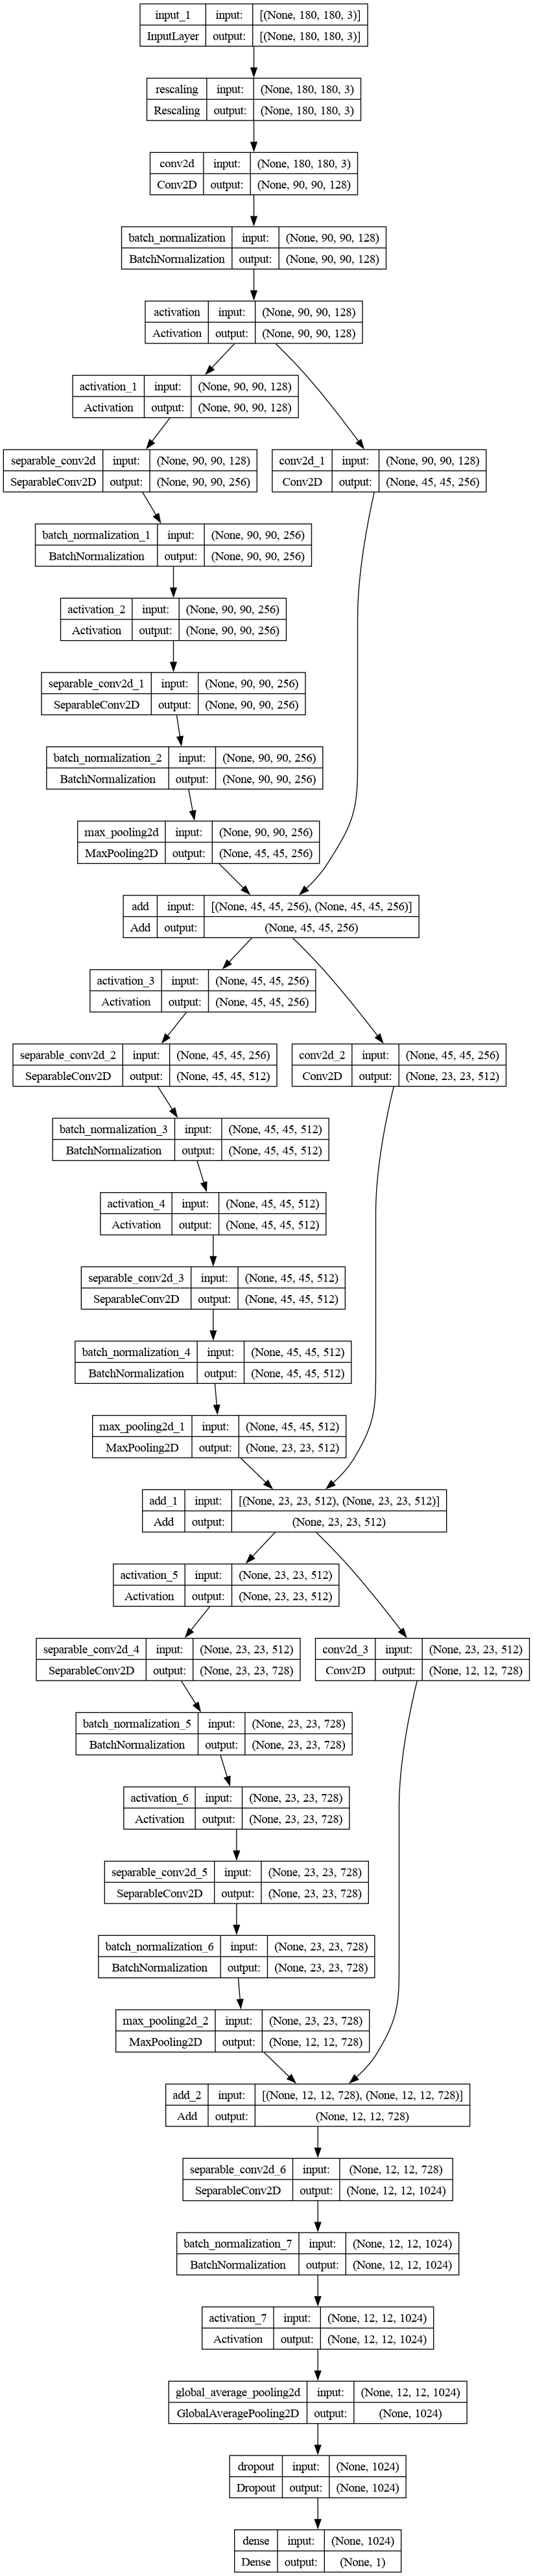

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=consts.IMAGE_SIZE + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [9]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


2023-10-03 10:30:20.967968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-10-03 10:30:23.077837: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbde8e30820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-03 10:30:23.077859: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-10-03 10:30:23.100696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-03 10:30:23.225329: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-10-03 10:30:23.430774: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.63GiB with freed_by_count=0. The c

 76/586 [==>...........................] - ETA: 2:20 - loss: 0.7418 - accuracy: 0.5785

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:47 - loss: 0.7134 - accuracy: 0.5905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:09 - loss: 0.6938 - accuracy: 0.6030

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:04 - loss: 0.6871 - accuracy: 0.6084

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 55s - loss: 0.6807 - accuracy: 0.6159

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 41s - loss: 0.6714 - accuracy: 0.6236

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 32s - loss: 0.6686 - accuracy: 0.6250

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 25s - loss: 0.6660 - accuracy: 0.6258

515/586 [=========================>....] - ETA: 19s - loss: 0.6636 - accuracy: 0.6282

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.6570 - accuracy: 0.6338

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.6353

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 187s 300ms/step - loss: 0.6555 - accuracy: 0.6353 - val_loss: 0.6469 - val_accuracy: 0.6123
Epoch 2/25
 76/586 [==>...........................] - ETA: 2:20 - loss: 0.5814 - accuracy: 0.6949

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:48 - loss: 0.5761 - accuracy: 0.6974

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:10 - loss: 0.5748 - accuracy: 0.7012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:04 - loss: 0.5692 - accuracy: 0.7049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 55s - loss: 0.5640 - accuracy: 0.7100

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 41s - loss: 0.5573 - accuracy: 0.7158

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 32s - loss: 0.5552 - accuracy: 0.7182

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 25s - loss: 0.5546 - accuracy: 0.7190

515/586 [=========================>....] - ETA: 19s - loss: 0.5518 - accuracy: 0.7208

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.5472 - accuracy: 0.7240

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.7256

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 175s 299ms/step - loss: 0.5452 - accuracy: 0.7256 - val_loss: 0.7708 - val_accuracy: 0.6235
Epoch 3/25
 76/586 [==>...........................] - ETA: 2:21 - loss: 0.4951 - accuracy: 0.7578

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:50 - loss: 0.4882 - accuracy: 0.7621

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.4855 - accuracy: 0.7668

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.4808 - accuracy: 0.7693

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 55s - loss: 0.4759 - accuracy: 0.7724

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 41s - loss: 0.4698 - accuracy: 0.7777

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.4688 - accuracy: 0.7796

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.4700 - accuracy: 0.7796

515/586 [=========================>....] - ETA: 19s - loss: 0.4689 - accuracy: 0.7804

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.4639 - accuracy: 0.7835

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.7834

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 176s 301ms/step - loss: 0.4630 - accuracy: 0.7834 - val_loss: 0.3906 - val_accuracy: 0.8381
Epoch 4/25
 76/586 [==>...........................] - ETA: 2:26 - loss: 0.3999 - accuracy: 0.8215

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:50 - loss: 0.3904 - accuracy: 0.8253

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.3890 - accuracy: 0.8280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.3853 - accuracy: 0.8299

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.3852 - accuracy: 0.8300

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.3820 - accuracy: 0.8324

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.3800 - accuracy: 0.8337

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.3817 - accuracy: 0.8330

515/586 [=========================>....] - ETA: 19s - loss: 0.3802 - accuracy: 0.8334

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.3786 - accuracy: 0.8333

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.8334

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 177s 302ms/step - loss: 0.3783 - accuracy: 0.8334 - val_loss: 0.3466 - val_accuracy: 0.8460
Epoch 5/25
 76/586 [==>...........................] - ETA: 2:22 - loss: 0.3656 - accuracy: 0.8409

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:49 - loss: 0.3374 - accuracy: 0.8531

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.3288 - accuracy: 0.8560

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.3261 - accuracy: 0.8573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 55s - loss: 0.3232 - accuracy: 0.8584

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 41s - loss: 0.3195 - accuracy: 0.8610

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.3186 - accuracy: 0.8613

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.3167 - accuracy: 0.8619

515/586 [=========================>....] - ETA: 19s - loss: 0.3168 - accuracy: 0.8616

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.3165 - accuracy: 0.8614

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8610

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 176s 301ms/step - loss: 0.3167 - accuracy: 0.8610 - val_loss: 1.1311 - val_accuracy: 0.6835
Epoch 6/25
 76/586 [==>...........................] - ETA: 2:22 - loss: 0.3050 - accuracy: 0.8754

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:49 - loss: 0.2804 - accuracy: 0.8823

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:10 - loss: 0.2726 - accuracy: 0.8867

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.2698 - accuracy: 0.8872

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 55s - loss: 0.2704 - accuracy: 0.8869

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.2711 - accuracy: 0.8866

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.2695 - accuracy: 0.8872

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.2686 - accuracy: 0.8874

515/586 [=========================>....] - ETA: 19s - loss: 0.2670 - accuracy: 0.8883

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.2693 - accuracy: 0.8870

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.8877

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 177s 301ms/step - loss: 0.2687 - accuracy: 0.8877 - val_loss: 0.2534 - val_accuracy: 0.9022
Epoch 7/25
 76/586 [==>...........................] - ETA: 2:22 - loss: 0.2590 - accuracy: 0.8890

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:50 - loss: 0.2418 - accuracy: 0.8985

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.2375 - accuracy: 0.9005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.2353 - accuracy: 0.9010

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.2344 - accuracy: 0.9016

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.2323 - accuracy: 0.9025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.2309 - accuracy: 0.9032

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.2326 - accuracy: 0.9024

515/586 [=========================>....] - ETA: 19s - loss: 0.2333 - accuracy: 0.9021

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.2331 - accuracy: 0.9017

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9021

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 177s 301ms/step - loss: 0.2333 - accuracy: 0.9021 - val_loss: 0.2244 - val_accuracy: 0.9003
Epoch 8/25
 76/586 [==>...........................] - ETA: 2:24 - loss: 0.2329 - accuracy: 0.9030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:50 - loss: 0.2227 - accuracy: 0.9105

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.2196 - accuracy: 0.9101

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.2171 - accuracy: 0.9110

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.2156 - accuracy: 0.9121

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.2153 - accuracy: 0.9118

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.2144 - accuracy: 0.9126

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.2147 - accuracy: 0.9130

515/586 [=========================>....] - ETA: 20s - loss: 0.2169 - accuracy: 0.9121

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.2160 - accuracy: 0.9122

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9126

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 178s 303ms/step - loss: 0.2159 - accuracy: 0.9126 - val_loss: 0.8808 - val_accuracy: 0.7439
Epoch 9/25
 76/586 [==>...........................] - ETA: 2:23 - loss: 0.2161 - accuracy: 0.9124

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:53 - loss: 0.2183 - accuracy: 0.9119

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:12 - loss: 0.2157 - accuracy: 0.9133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:06 - loss: 0.2134 - accuracy: 0.9135

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 57s - loss: 0.2129 - accuracy: 0.9126

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.2149 - accuracy: 0.9118

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.2114 - accuracy: 0.9133

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.2116 - accuracy: 0.9127

515/586 [=========================>....] - ETA: 20s - loss: 0.2104 - accuracy: 0.9133

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.2104 - accuracy: 0.9131

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9133

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 179s 305ms/step - loss: 0.2097 - accuracy: 0.9133 - val_loss: 0.2053 - val_accuracy: 0.9144
Epoch 10/25
 76/586 [==>...........................] - ETA: 2:28 - loss: 0.2089 - accuracy: 0.9174

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:56 - loss: 0.1982 - accuracy: 0.9186

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:15 - loss: 0.1879 - accuracy: 0.9237

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:09 - loss: 0.1851 - accuracy: 0.9255

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 59s - loss: 0.1832 - accuracy: 0.9260

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 44s - loss: 0.1839 - accuracy: 0.9257

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 35s - loss: 0.1846 - accuracy: 0.9255

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.1845 - accuracy: 0.9253

515/586 [=========================>....] - ETA: 21s - loss: 0.1851 - accuracy: 0.9249

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1875 - accuracy: 0.9241

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9240

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 187s 319ms/step - loss: 0.1879 - accuracy: 0.9240 - val_loss: 0.2600 - val_accuracy: 0.8945
Epoch 11/25
 76/586 [==>...........................] - ETA: 2:29 - loss: 0.1876 - accuracy: 0.9211

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:52 - loss: 0.1808 - accuracy: 0.9233

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:12 - loss: 0.1804 - accuracy: 0.9258

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:06 - loss: 0.1777 - accuracy: 0.9264

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.1753 - accuracy: 0.9279

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.1726 - accuracy: 0.9295

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.1723 - accuracy: 0.9288

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1717 - accuracy: 0.9292

515/586 [=========================>....] - ETA: 20s - loss: 0.1715 - accuracy: 0.9292

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1720 - accuracy: 0.9292

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9293

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 179s 306ms/step - loss: 0.1721 - accuracy: 0.9293 - val_loss: 0.1548 - val_accuracy: 0.9383
Epoch 12/25
 76/586 [==>...........................] - ETA: 2:22 - loss: 0.1763 - accuracy: 0.9227

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:50 - loss: 0.1685 - accuracy: 0.9299

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:14 - loss: 0.1668 - accuracy: 0.9311

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:08 - loss: 0.1656 - accuracy: 0.9319

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 58s - loss: 0.1639 - accuracy: 0.9326

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 43s - loss: 0.1621 - accuracy: 0.9342

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 34s - loss: 0.1615 - accuracy: 0.9345

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.1636 - accuracy: 0.9338

515/586 [=========================>....] - ETA: 20s - loss: 0.1629 - accuracy: 0.9342

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1622 - accuracy: 0.9346

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9343

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 187s 318ms/step - loss: 0.1635 - accuracy: 0.9343 - val_loss: 0.1315 - val_accuracy: 0.9509
Epoch 13/25
 76/586 [==>...........................] - ETA: 2:33 - loss: 0.1642 - accuracy: 0.9326

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:55 - loss: 0.1536 - accuracy: 0.9380

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:13 - loss: 0.1535 - accuracy: 0.9378

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:07 - loss: 0.1512 - accuracy: 0.9388

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 57s - loss: 0.1476 - accuracy: 0.9400

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 43s - loss: 0.1475 - accuracy: 0.9404

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 34s - loss: 0.1482 - accuracy: 0.9398

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1483 - accuracy: 0.9398

515/586 [=========================>....] - ETA: 20s - loss: 0.1509 - accuracy: 0.9389

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1510 - accuracy: 0.9387

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9386

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 180s 306ms/step - loss: 0.1507 - accuracy: 0.9386 - val_loss: 0.2779 - val_accuracy: 0.8936
Epoch 14/25
 76/586 [==>...........................] - ETA: 2:25 - loss: 0.1381 - accuracy: 0.9445

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:51 - loss: 0.1419 - accuracy: 0.9425

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.1386 - accuracy: 0.9451

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.1371 - accuracy: 0.9455

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.1370 - accuracy: 0.9458

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.1371 - accuracy: 0.9453

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.1356 - accuracy: 0.9461

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1349 - accuracy: 0.9461

515/586 [=========================>....] - ETA: 20s - loss: 0.1369 - accuracy: 0.9451

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1368 - accuracy: 0.9452

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9455

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 179s 305ms/step - loss: 0.1367 - accuracy: 0.9455 - val_loss: 0.1281 - val_accuracy: 0.9515
Epoch 15/25
 76/586 [==>...........................] - ETA: 2:25 - loss: 0.1522 - accuracy: 0.9383

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:52 - loss: 0.1375 - accuracy: 0.9440

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:13 - loss: 0.1346 - accuracy: 0.9456

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:07 - loss: 0.1312 - accuracy: 0.9472

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 57s - loss: 0.1315 - accuracy: 0.9475

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 43s - loss: 0.1326 - accuracy: 0.9468

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 34s - loss: 0.1330 - accuracy: 0.9466

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1331 - accuracy: 0.9468

515/586 [=========================>....] - ETA: 20s - loss: 0.1340 - accuracy: 0.9462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1346 - accuracy: 0.9458

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9459

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 182s 310ms/step - loss: 0.1352 - accuracy: 0.9459 - val_loss: 0.2034 - val_accuracy: 0.9263
Epoch 16/25
 76/586 [==>...........................] - ETA: 2:23 - loss: 0.1717 - accuracy: 0.9326

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:50 - loss: 0.1526 - accuracy: 0.9393

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.1448 - accuracy: 0.9426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.1422 - accuracy: 0.9439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.1386 - accuracy: 0.9454

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.1383 - accuracy: 0.9453

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.1372 - accuracy: 0.9455

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1392 - accuracy: 0.9446

515/586 [=========================>....] - ETA: 20s - loss: 0.1398 - accuracy: 0.9447

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1386 - accuracy: 0.9455

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9457

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 177s 303ms/step - loss: 0.1381 - accuracy: 0.9457 - val_loss: 0.1133 - val_accuracy: 0.9592
Epoch 17/25
 76/586 [==>...........................] - ETA: 2:24 - loss: 0.1484 - accuracy: 0.9387

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:51 - loss: 0.1347 - accuracy: 0.9453

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:12 - loss: 0.1310 - accuracy: 0.9469

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:06 - loss: 0.1291 - accuracy: 0.9479

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.1272 - accuracy: 0.9486

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.1252 - accuracy: 0.9494

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.1251 - accuracy: 0.9494

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1253 - accuracy: 0.9494

515/586 [=========================>....] - ETA: 20s - loss: 0.1253 - accuracy: 0.9495

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1259 - accuracy: 0.9495

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9495

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 179s 306ms/step - loss: 0.1262 - accuracy: 0.9495 - val_loss: 0.1674 - val_accuracy: 0.9319
Epoch 18/25
 76/586 [==>...........................] - ETA: 2:23 - loss: 0.1651 - accuracy: 0.9350

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:54 - loss: 0.1343 - accuracy: 0.9467

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:13 - loss: 0.1293 - accuracy: 0.9474

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:06 - loss: 0.1273 - accuracy: 0.9481

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 57s - loss: 0.1244 - accuracy: 0.9492

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 43s - loss: 0.1243 - accuracy: 0.9495

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 34s - loss: 0.1241 - accuracy: 0.9495

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1224 - accuracy: 0.9503

515/586 [=========================>....] - ETA: 20s - loss: 0.1225 - accuracy: 0.9504

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1212 - accuracy: 0.9510

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9512

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 181s 308ms/step - loss: 0.1208 - accuracy: 0.9512 - val_loss: 0.1097 - val_accuracy: 0.9560
Epoch 19/25
 76/586 [==>...........................] - ETA: 2:23 - loss: 0.1232 - accuracy: 0.9474

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:51 - loss: 0.1238 - accuracy: 0.9485

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:12 - loss: 0.1169 - accuracy: 0.9528

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:06 - loss: 0.1164 - accuracy: 0.9529

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.1161 - accuracy: 0.9530

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.1164 - accuracy: 0.9525

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.1156 - accuracy: 0.9532

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1154 - accuracy: 0.9533

515/586 [=========================>....] - ETA: 20s - loss: 0.1161 - accuracy: 0.9530

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1165 - accuracy: 0.9529

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9530

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 179s 306ms/step - loss: 0.1162 - accuracy: 0.9530 - val_loss: 0.1731 - val_accuracy: 0.9385
Epoch 20/25
 76/586 [==>...........................] - ETA: 2:24 - loss: 0.1073 - accuracy: 0.9556

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:50 - loss: 0.1171 - accuracy: 0.9553

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:11 - loss: 0.1124 - accuracy: 0.9575

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:05 - loss: 0.1105 - accuracy: 0.9584

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 56s - loss: 0.1107 - accuracy: 0.9582

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.1111 - accuracy: 0.9582

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.1106 - accuracy: 0.9584

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1102 - accuracy: 0.9584

515/586 [=========================>....] - ETA: 20s - loss: 0.1120 - accuracy: 0.9576

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1116 - accuracy: 0.9577

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9576

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 181s 308ms/step - loss: 0.1122 - accuracy: 0.9576 - val_loss: 0.1085 - val_accuracy: 0.9560
Epoch 21/25
 76/586 [==>...........................] - ETA: 2:29 - loss: 0.1275 - accuracy: 0.9498

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:55 - loss: 0.1110 - accuracy: 0.9581

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:13 - loss: 0.1114 - accuracy: 0.9576

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:06 - loss: 0.1095 - accuracy: 0.9580

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 57s - loss: 0.1081 - accuracy: 0.9582

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 42s - loss: 0.1099 - accuracy: 0.9570

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 33s - loss: 0.1095 - accuracy: 0.9572

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.1102 - accuracy: 0.9569

515/586 [=========================>....] - ETA: 20s - loss: 0.1101 - accuracy: 0.9570

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1083 - accuracy: 0.9575

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9578

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 180s 307ms/step - loss: 0.1078 - accuracy: 0.9578 - val_loss: 0.1185 - val_accuracy: 0.9596
Epoch 22/25
 76/586 [==>...........................] - ETA: 2:31 - loss: 0.1205 - accuracy: 0.9515

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:56 - loss: 0.1042 - accuracy: 0.9584

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:15 - loss: 0.1033 - accuracy: 0.9606

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:09 - loss: 0.1013 - accuracy: 0.9612

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 59s - loss: 0.1000 - accuracy: 0.9615

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 44s - loss: 0.0994 - accuracy: 0.9619

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 35s - loss: 0.1014 - accuracy: 0.9608

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.1008 - accuracy: 0.9609

515/586 [=========================>....] - ETA: 21s - loss: 0.1022 - accuracy: 0.9605

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1030 - accuracy: 0.9597

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9596

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 187s 318ms/step - loss: 0.1032 - accuracy: 0.9596 - val_loss: 0.0957 - val_accuracy: 0.9639
Epoch 23/25
 76/586 [==>...........................] - ETA: 2:29 - loss: 0.1108 - accuracy: 0.9556

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:58 - loss: 0.1091 - accuracy: 0.9576

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:15 - loss: 0.1035 - accuracy: 0.9598

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:09 - loss: 0.1021 - accuracy: 0.9600

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 59s - loss: 0.1003 - accuracy: 0.9600 

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 44s - loss: 0.1008 - accuracy: 0.9594

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 35s - loss: 0.1017 - accuracy: 0.9587

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.1023 - accuracy: 0.9587

515/586 [=========================>....] - ETA: 21s - loss: 0.1025 - accuracy: 0.9582

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.1012 - accuracy: 0.9589

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9590

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 188s 321ms/step - loss: 0.1009 - accuracy: 0.9590 - val_loss: 0.2465 - val_accuracy: 0.9109
Epoch 24/25
 76/586 [==>...........................] - ETA: 2:32 - loss: 0.1093 - accuracy: 0.9560

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:57 - loss: 0.1099 - accuracy: 0.9547

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:15 - loss: 0.1044 - accuracy: 0.9569

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:09 - loss: 0.1021 - accuracy: 0.9579

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 59s - loss: 0.1010 - accuracy: 0.9583

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 44s - loss: 0.0994 - accuracy: 0.9591

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 35s - loss: 0.0983 - accuracy: 0.9594

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.0974 - accuracy: 0.9601

515/586 [=========================>....] - ETA: 21s - loss: 0.0968 - accuracy: 0.9603

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.0960 - accuracy: 0.9609

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 187s 320ms/step - loss: 0.0960 - accuracy: 0.9609 - val_loss: 0.1172 - val_accuracy: 0.9543
Epoch 25/25
 76/586 [==>...........................] - ETA: 2:31 - loss: 0.1148 - accuracy: 0.9560

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


193/586 [========>.....................] - ETA: 1:56 - loss: 0.1042 - accuracy: 0.9581

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


332/586 [===============>..............] - ETA: 1:15 - loss: 0.1004 - accuracy: 0.9608

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


353/586 [=================>............] - ETA: 1:09 - loss: 0.0981 - accuracy: 0.9620

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


386/586 [==================>...........] - ETA: 59s - loss: 0.0966 - accuracy: 0.9628

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/586 [=====================>........] - ETA: 44s - loss: 0.0972 - accuracy: 0.9629

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 35s - loss: 0.0957 - accuracy: 0.9635

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.0963 - accuracy: 0.9634

515/586 [=========================>....] - ETA: 21s - loss: 0.0970 - accuracy: 0.9629

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


567/586 [============================>.] - ETA: 5s - loss: 0.0964 - accuracy: 0.9632

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9632

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


586/586 [==============================] - 187s 319ms/step - loss: 0.0967 - accuracy: 0.9632 - val_loss: 0.0930 - val_accuracy: 0.9633


In [12]:
px.line(history.history)

## Inference

In [16]:
import tensorflow as tf
from PIL import Image, ImageOps
import requests
import io
import plotly.express as px
import consts

import plotly.io as pio
pio.renderers.default='iframe'

def classify(url):
    global model
    try: model
    except:
        model = tf.keras.models.load_model('save_at_25.keras')
    req = requests.get(url)
    img = Image.open(io.BytesIO(req.content))
    img = ImageOps.fit(img, size=consts.IMAGE_SIZE)
    
    ids = tf.expand_dims(tf.keras.utils.img_to_array(img), 0)
    pred = model.predict(ids)
    score = float(pred[0, 0])
    if score < 0.5:
        return 'Cat', 1-score, img
    else:
        return 'Dog', score, img

def classify_plot(url):
    category, probability, img = classify(url)
    fig = px.imshow(img, title='%s (%.4f%%)' % (category, probability * 100))
    fig.show()

In [17]:
classify_plot('https://i.guim.co.uk/img/media/26392d05302e02f7bf4eb143bb84c8097d09144b/446_167_3683_2210/master/3683.jpg?width=1200&quality=85&auto=format&fit=max&s=a52bbe202f57ac0f5ff7f47166906403')

1/1 [==============================] - 0s 15ms/step


In [46]:
classify_plot('https://cdn.jwplayer.com/v2/media/KdhsB08g/poster.jpg?width=720')

1/1 [==============================] - 0s 19ms/step


In [47]:
classify_plot('https://publish.purewow.net/wp-content/uploads/sites/2/2021/06/smallest-dog-breeds-toy-poodle.jpg')

1/1 [==============================] - 0s 17ms/step


In [50]:
classify_plot('https://www.cdc.gov/healthypets/images/pets/cute-dog-headshot.jpg')

1/1 [==============================] - 0s 15ms/step


In [51]:
classify_plot('https://petsmartgo.com/wp-content/uploads/2021/12/Husky-Wolf-Like-Dog.png')

1/1 [==============================] - 0s 17ms/step


In [52]:
classify_plot('https://www.dogledesign.hu/wp-content/uploads/2022/12/Azawakh1.jpg')

1/1 [==============================] - 0s 15ms/step
